# Nursing Home Objects Image Classification via Neural Network

This notebook goes through end to end data retrieval from s3, data preprocessing, model building, and model evaluation.

In [2]:
!pip install tensorflow==2.15 boto3==1.34.94 matplotlib==3.8.4 pillow==10.3.0 numpy==1.26.4

In [3]:
import numpy as np
import os
import tensorflow as tf
import boto3
import io
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-04-30 18:15:40.972904: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 18:15:41.654881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 18:15:41.654938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 18:15:41.793473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 18:15:42.064102: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 18:15:42.066820: I tensorflow/core/platform/cpu_feature_guard.cc:1

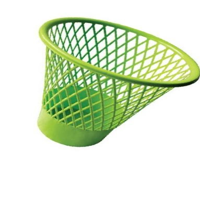

In [4]:
# Initialize S3 client
s3 = boto3.client('s3')

# Specify your bucket and prefix (directory)
bucket_name = 'bigdata-project-data'
prefix = 'uva-projects/nursing_home_data/basket_bin/'

# Use list_objects_v2 to list objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Iterate over the objects and open the first image
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.lower().endswith('.jpg'):  # Assuming JPEG images
        # Download the image
        image_object = s3.get_object(Bucket=bucket_name, Key=key)
        # Open the image using PIL
        image = Image.open(io.BytesIO(image_object['Body'].read()))
        # Resize the image to a smaller size
        # Change (width, height) to your desired size
        smaller_image = image.resize((200, 200))
        # Display the resized image
        smaller_image.show()
        # Break out of the loop after opening the first image
        break

## Load Data to Directory from S3 bucket

- load from s3 bucket 'bigdata-project-data' to local directory and format into tensorflow keras format.
- split data into 80% training, 10% validation, and 10% test.
- EDA on images and labels as well as data distribution of classes.



Run this in terminal (preferred) or notebook with your local path second. Alternatively download dataset from github readme dataset link into local directory.

In [5]:
#!aws s3 sync s3://bigdata-project-data/uva-projects/nursing_home_data /home/sagemaker-user/bigdata-project/data

In [6]:
# Define your local data directory (where you want to download the data)
local_data_dir = '/home/sagemaker-user/project/data'

# Use tf.keras.utils.image_dataset_from_directory with the local directory
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 36981 files belonging to 25 classes.
Using 29585 files for training.


In [7]:
train_ds.class_names

['basket_bin',
 'bed',
 'bench',
 'cabinet',
 'call_bell',
 'cane_stick',
 'chair',
 'door',
 'electric_socket',
 'fan',
 'fire_extinguisher',
 'handrail',
 'human_being',
 'rack',
 'refrigerator',
 'shower',
 'sink',
 'sofa',
 'table',
 'television',
 'toilet_seat',
 'walker',
 'wardrobe',
 'water_dispencer',
 'wheelchair']

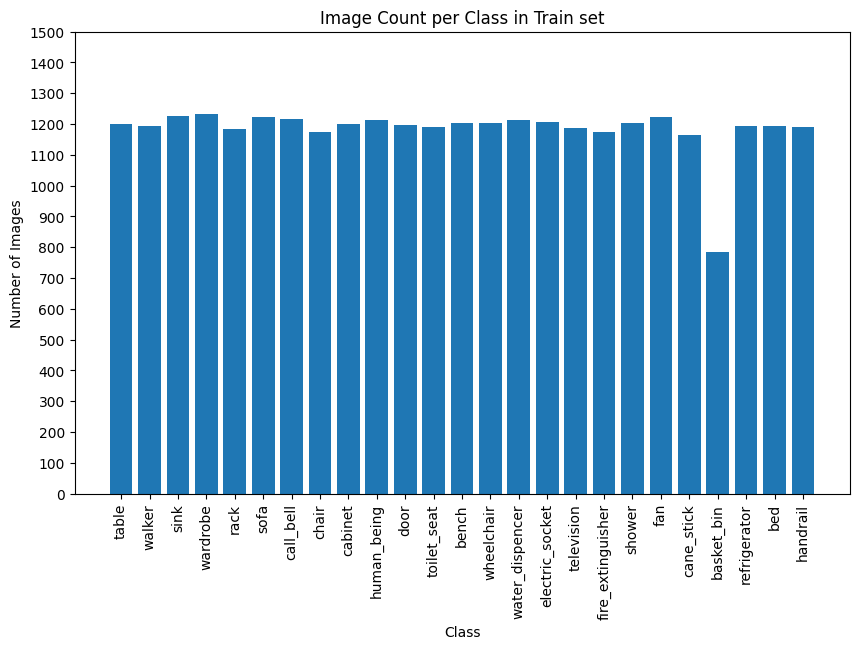

In [8]:
# Get the class names from the dataset
class_names = train_ds.class_names

# Count the number of images in each class
class_counts = {}
for image_batch, label_batch in train_ds:
    for label in label_batch:
        class_name = class_names[label.numpy()]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Create a bar chart of the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Train set')
plt.xticks(rotation=90)

# Set the y-axis intervals to multiples of 100
max_count = max(class_counts.values())+200
interval = 100
yticks = list(range(0, max_count + interval, interval))
plt.yticks(yticks)

plt.show()

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  local_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 36981 files belonging to 25 classes.
Using 7396 files for validation.


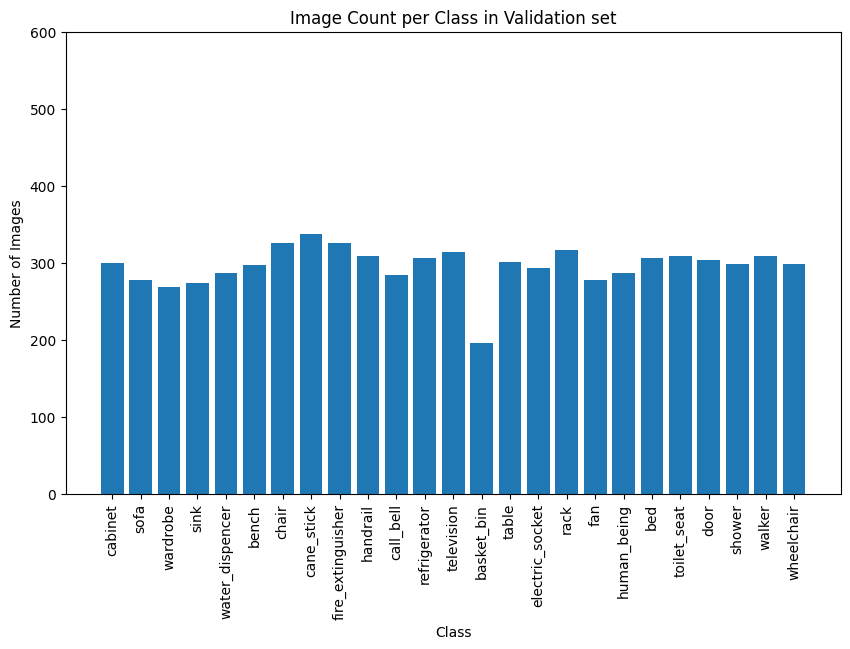

In [10]:
# Get the class names from the dataset
class_names = val_ds.class_names

# Count the number of images in each class
class_counts = {}
for image_batch, label_batch in val_ds:
    for label in label_batch:
        class_name = class_names[label.numpy()]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Create a bar chart of the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Validation set')
plt.xticks(rotation=90)

# Set the y-axis intervals to multiples of 100
max_count = max(class_counts.values())+200
interval = 100
yticks = list(range(0, max_count + interval, interval))
plt.yticks(yticks)

plt.show()

In [11]:
len(train_ds.class_names)

25

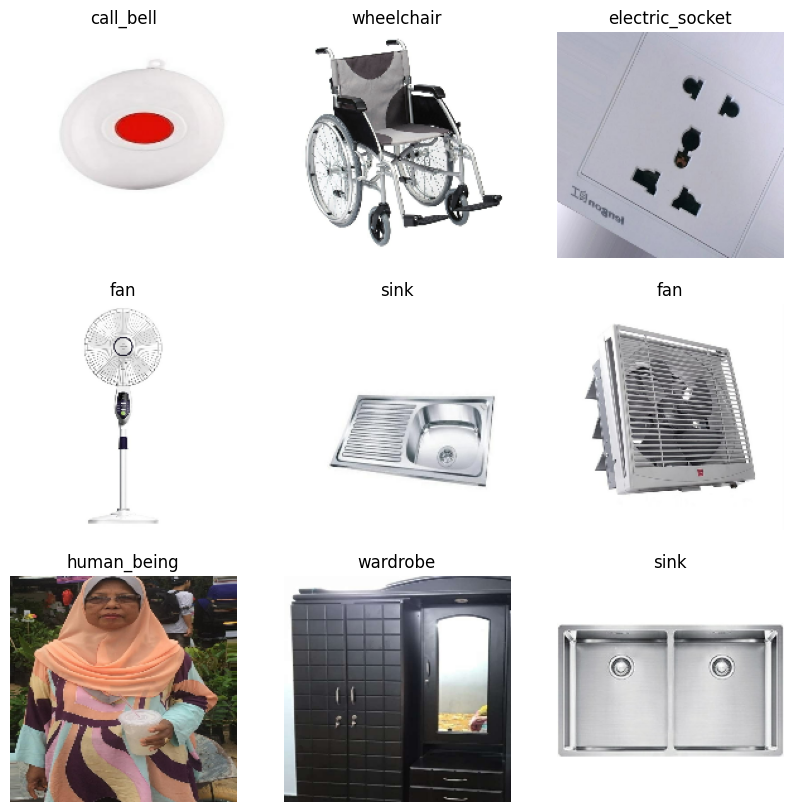

In [12]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 116
Number of test batches: 116


Buffer prefetching to optimize data retrieval performance.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Data augmentation to increase data diversity in training data.

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

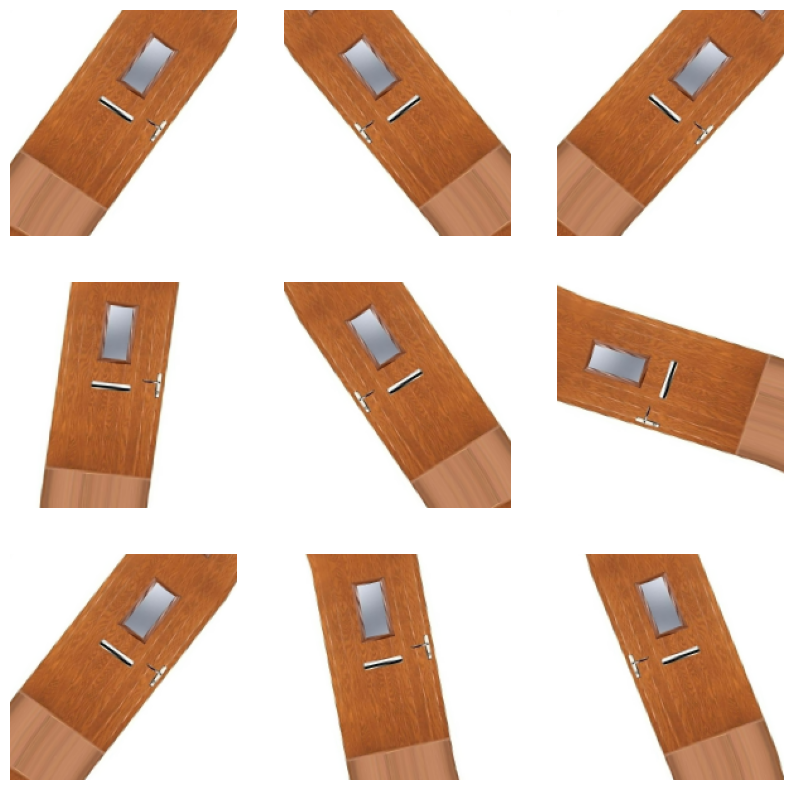

In [17]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Building Model Pipeline using ResNet50 pre-trained model. 

In [18]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [19]:
# Define the input shape and image size
IMG_SIZE = (180, 180)
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [20]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


Freeze pretrained ResNet50 model layers.

In [21]:
base_model.trainable = False

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [23]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


In [24]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Model Architecture in table below.

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

### Model Training Parameters

In [26]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
loss0, accuracy0 = model.evaluate(val_ds)

116/116 [==============================] - 82s 659ms/step - loss: 3.9476 - accuracy: 0.0288


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.95
initial accuracy: 0.03


### Note: model training below takes ~11min per epoch.

In [29]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5


925/925 [==============================] - 712s 767ms/step - loss: 0.5016 - accuracy: 0.8447 - val_loss: 0.1909 - val_accuracy: 0.9368
Epoch 2/5
925/925 [==============================] - 716s 774ms/step - loss: 0.2559 - accuracy: 0.9185 - val_loss: 0.1476 - val_accuracy: 0.9522
Epoch 3/5
925/925 [==============================] - 723s 782ms/step - loss: 0.2259 - accuracy: 0.9263 - val_loss: 0.1444 - val_accuracy: 0.9522
Epoch 4/5
925/925 [==============================] - 723s 782ms/step - loss: 0.1962 - accuracy: 0.9380 - val_loss: 0.1322 - val_accuracy: 0.9582
Epoch 5/5
925/925 [==============================] - 719s 777ms/step - loss: 0.1927 - accuracy: 0.9385 - val_loss: 0.1405 - val_accuracy: 0.9566


### ResNet50 trained with Nursing Home Images Evaluation

Text(0.5, 1.0, 'Training and Validation Loss')

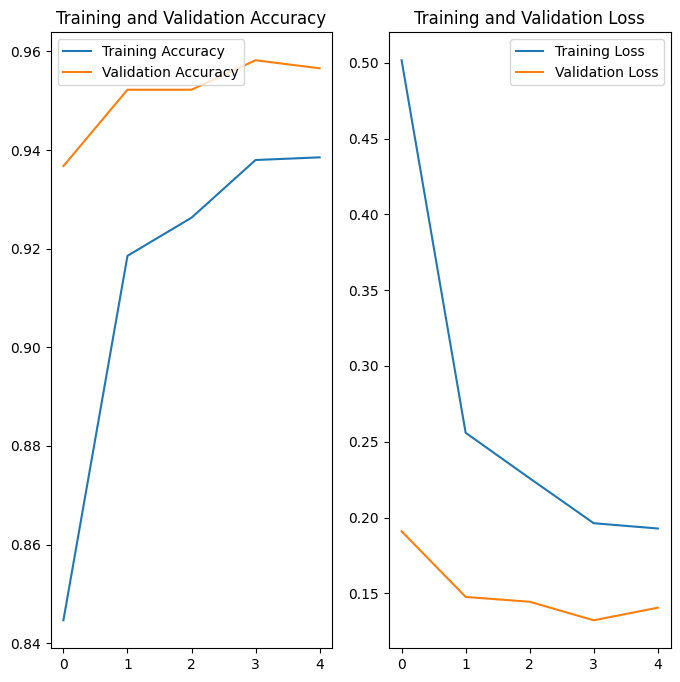

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [31]:
loss, accuracy = model.evaluate(test_ds)
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)

116/116 [==============================] - 80s 686ms/step - loss: 0.1372 - accuracy: 0.9534
Test Accuracy: 0.9533944129943848
Test Loss: 0.1372458040714264


Predictions:
 [ 6 22 17 19 10 15 13 20 22 17 20 12 19  9  5  6 23 15  3 18 13 11 14 13
 20 14 17 19  6 11 17 21]
Labels:
 [ 6 22 17 19 10 15 13 20  3 17 20 12 19  9  5  6 23 15  3 18 13 11 14 13
 20 14 17 19  6 11 17 21]


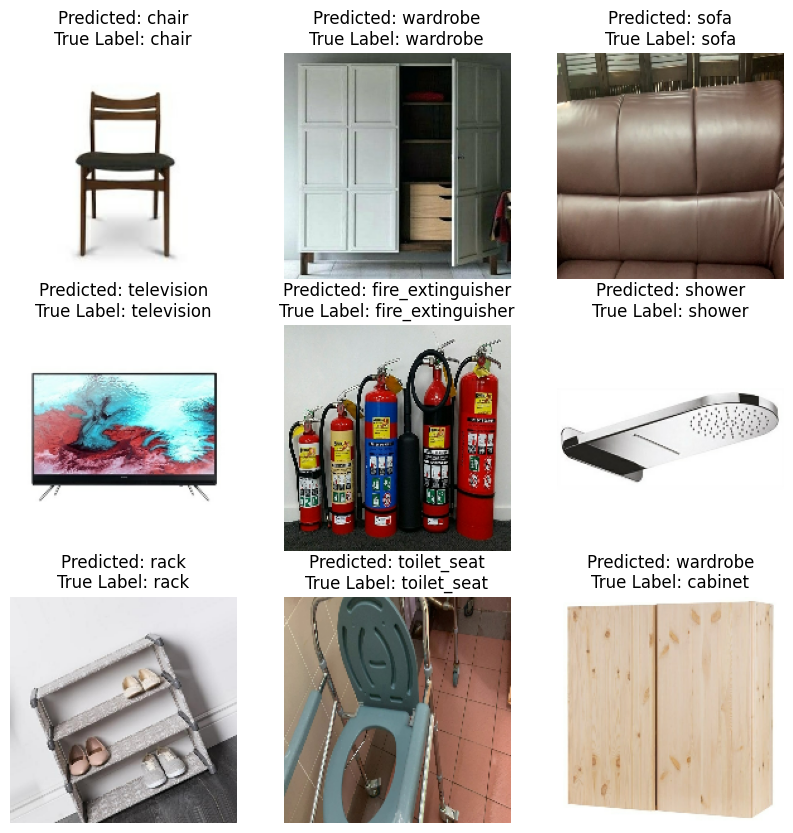

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)

# Apply softmax to convert logits to probabilities
predictions = tf.nn.softmax(predictions, axis=-1)

# Get the predicted class indices
predicted_class_indices = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class_indices.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    predicted_class_index = predicted_class_indices[i].numpy()
    true_label = label_batch[i]
    plt.title(f"Predicted: {class_names[predicted_class_index]}\nTrue Label: {class_names[true_label]}")
    plt.axis("off")

## Save model in h5 format to local directory to create endpoint in deploy and create endpoint notebook.

In [33]:
model.save('/home/sagemaker-user/project/models/resnet50_trained/full_resnet50_trained_model.h5')